In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score


# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, SimpleRNN
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
nltk.download('omw-1.4')

# Word2vec
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec


# Utility
import string
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import random
import datetime

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
df = pd.read_csv("Twitter_Data.csv")
df1 = df

In [4]:
df.head(5)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [5]:
df = df[df.category != 0.0]

**Note:** I have removed neutral comments as I wanted to perform analysis specific to Negative and Positive sentiments

In [6]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107767 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  107765 non-null  object 
 1   category    107760 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [7]:
DATASET_COLUMNS = ["clean_text", "category"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

SEQUENCE_LENGTH = 300
EPOCHS = 5
BATCH_SIZE = 1024

POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250


In [8]:
df.isnull().sum()

clean_text    2
category      7
dtype: int64

In [9]:
df.dropna(how='any', inplace=True)
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [10]:
decode_map = {-1.0: "NEGATIVE", 1.0: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [11]:
%%time
df.category = df.category.apply(lambda x: decode_sentiment(x))

CPU times: user 79.4 ms, sys: 1.82 ms, total: 81.2 ms
Wall time: 88.1 ms


In [12]:
stop_words = set(stopwords.words("english"))
stop_words.remove('not')
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
stop_words = stop_words.union(more_stopwords)

stemmer = SnowballStemmer("english")

In [13]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'^[^ ]<.*?>|&([a-z0-9]+|#[0-9]\"\'\“{1,6}|#x[0-9a-f]{1,6});[^A-Za-z0-9]+')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)


# Applying helper functions

df['mod_text'] = df['clean_text'].apply(lambda x: remove_URL(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_emoji(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_html(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_punct(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_quotes(x))

In [14]:
df['tokenized'] = df['mod_text'].apply(word_tokenize)

In [15]:
# Lower casing clean text.

df['lower'] = df['tokenized'].apply(
    lambda x: [word.lower() for word in x])

In [16]:
# Removing stopwords.

df['stopwords_removed'] = df['lower'].apply(
    lambda x: [word for word in x if word not in stop_words])

In [17]:
# Applying part of speech tags.

df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)

In [18]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


df['wordnet_pos'] = df['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [19]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

df['lemmatized'] = df['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

df['lemmatized'] = df['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop_words])

df['Final'] = [' '.join(map(str, l)) for l in df['lemmatized']]

In [20]:
print("Total Rows =", len(df.clean_text))

Total Rows = 107758


In [21]:
df.head()

,clean_text,category,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,Final
0,when modi promised “minimum government maximum...,NEGATIVE,when modi promised minimum government maximum ...,"[when, modi, promised, minimum, government, ma...","[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[(modi, NNS), (promised, VBD), (minimum, JJ), ...","[(modi, n), (promised, v), (minimum, a), (gove...","[modi, promise, minimum, government, maximum, ...",modi promise minimum government maximum govern...
2,what did just say vote for modi welcome bjp t...,POSITIVE,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...","[(say, VB), (vote, NN), (modi, FW), (welcome, ...","[(say, v), (vote, n), (modi, n), (welcome, a),...","[say, vote, modi, welcome, bjp, tell, rahul, m...",say vote modi welcome bjp tell rahul main camp...
3,asking his supporters prefix chowkidar their n...,POSITIVE,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[(asking, VBG), (supporters, NNS), (prefix, VB...","[(asking, v), (supporters, n), (prefix, v), (c...","[ask, supporter, prefix, chowkidar, name, modi...",ask supporter prefix chowkidar name modi great...
4,answer who among these the most powerful world...,POSITIVE,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...","[(answer, NN), (among, IN), (powerful, JJ), (w...","[(answer, n), (among, n), (powerful, a), (worl...","[answer, among, powerful, world, leader, today...",answer among powerful world leader today trump...
8,with upcoming election india saga going import...,POSITIVE,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[with, upcoming, election, india, saga, going,...","[upcoming, election, india, saga, going, impor...","[(upcoming, JJ), (election, NN), (india, NN), ...","[(upcoming, a), (election, n), (india, n), (sa...","[upcoming, election, india, saga, go, importan...",upcoming election india saga go important pair...


In [22]:
df_mod = df[["Final", "category"]]
df_mod.head()

,Final,category
0,modi promise minimum government maximum govern...,NEGATIVE
2,say vote modi welcome bjp tell rahul main camp...,POSITIVE
3,ask supporter prefix chowkidar name modi great...,POSITIVE
4,answer among powerful world leader today trump...,POSITIVE
8,upcoming election india saga go important pair...,POSITIVE


In [23]:
df_train, df_test = train_test_split(df_mod, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 86206
TEST size: 21552


In [25]:
%%time
documents = [text.split() for text in df_train.Final]

CPU times: user 302 ms, sys: 310 ms, total: 612 ms
Wall time: 1.2 s


In [26]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

In [27]:
w2v_model.build_vocab(documents)

In [28]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)


Vocab size 8353


In [29]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 3min 10s, sys: 813 ms, total: 3min 10s
Wall time: 2min 8s


(37099833, 45364480)

In [30]:
w2v_model.wv.most_similar("bjp")

[('party', 0.4462733864784241),
 ('trs', 0.44043219089508057),
 ('jds', 0.4131690263748169),
 ('ncp', 0.4078805148601532),
 ('cadre', 0.4061238467693329),
 ('coalition', 0.4005206525325775),
 ('dmk', 0.387603223323822),
 ('karnataka', 0.3758443295955658),
 ('mp', 0.36456185579299927),
 ('rjd', 0.36244484782218933)]

In [32]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.Final)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 70297
CPU times: user 3.59 s, sys: 37.6 ms, total: 3.63 s
Wall time: 7.23 s


In [34]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.Final), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.Final), maxlen=SEQUENCE_LENGTH)

CPU times: user 3.51 s, sys: 124 ms, total: 3.64 s
Wall time: 4.26 s


In [35]:
labels = df_train.category.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [36]:
encoder = LabelEncoder()
encoder.fit(df_train.category.tolist())

y_train = encoder.transform(df_train.category.tolist())
y_test = encoder.transform(df_test.category.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (86206, 1)
y_test (21552, 1)


In [37]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (86206, 300)
y_train (86206, 1)

x_test (21552, 300)
y_test (21552, 1)


In [38]:
y_train[:10]

array([[1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1]])

In [39]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(70297, 300)


In [40]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [41]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(SimpleRNN(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          21089100  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 21129301 (80.60 MB)
Trainable params: 40201 (157.04 KB)
Non-trainable params: 21089100 (80.45 MB)
_________________________________________________________________


In [42]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [43]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [44]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/5
76/76 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.6095

76/76 [==============================] - 403s 5s/step - loss: 0.6680 - accuracy: 0.6095 - val_loss: 0.6095 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 2/5
76/76 [==============================] - ETA: 0s - loss: 0.6312 - accuracy: 0.6472

76/76 [==============================] - 372s 5s/step - loss: 0.6312 - accuracy: 0.6472 - val_loss: 0.6049 - val_accuracy: 0.6745 - lr: 0.0010
Epoch 3/5
76/76 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.6524

76/76 [==============================] - 374s 5s/step - loss: 0.6237 - accuracy: 0.6524 - val_loss: 0.5969 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 4/5
76/76 [==============================] - ETA: 0s - loss: 0.6162 - accuracy: 0.6616

76/76 [==============================] - 378s 5s/step - loss: 0.6162 - accuracy: 0.6616 - val_loss: 0.5877 - val_accuracy: 0.6857 - lr: 0.0010
Epoch 5/5
76/76 [==============================] - ETA: 0s - loss: 0.6102 - accuracy: 0.6677

76/76 [==============================] - 363s 5s/step - loss: 0.6102 - accuracy: 0.6677 - val_loss: 0.5765 - val_accuracy: 0.6946 - lr: 0.0010
CPU times: user 40min 15s, sys: 6min 26s, total: 46min 42s
Wall time: 32min 27s


In [45]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

22/22 [==============================] - 25s 1s/step - loss: 0.5828 - accuracy: 0.6934

ACCURACY: 0.6933927536010742
LOSS: 0.5827869176864624
CPU times: user 29.8 s, sys: 10.3 s, total: 40.1 s
Wall time: 41.1 s


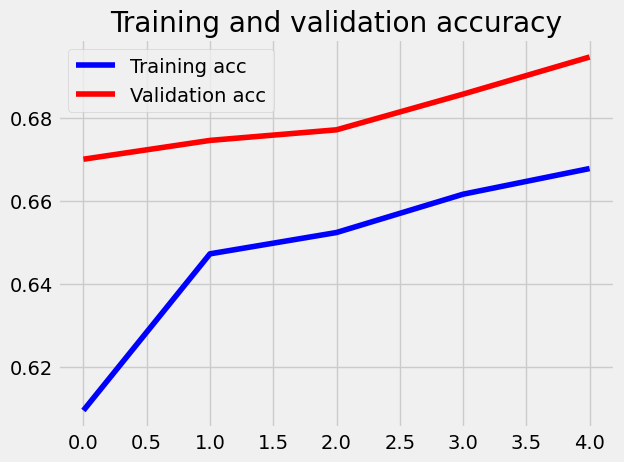

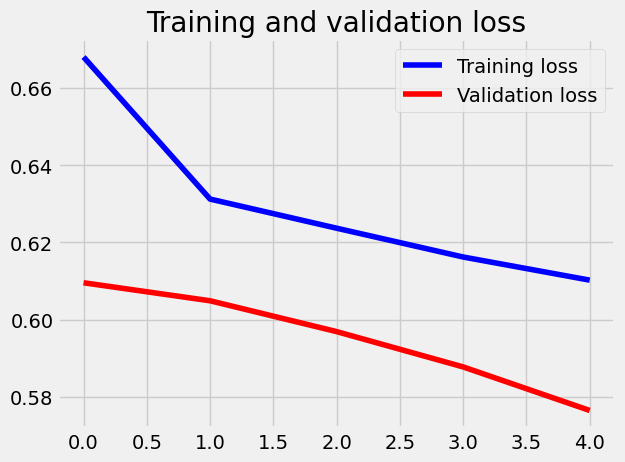

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [48]:
def predict(clean_text, include_neutral=True):
    start_at = time.time()
    # Tokenize clean_text
    x_test = pad_sequences(tokenizer.texts_to_sequences([clean_text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [49]:
predict("I love the music")

1/1 [==============================] - 0s 321ms/step


{'label': 'POSITIVE',
 'score': 0.8100494742393494,
 'elapsed_time': 0.38237667083740234}

In [50]:
predict("I have nothing to lose")

1/1 [==============================] - 0s 58ms/step


{'label': 'NEUTRAL',
 'score': 0.6475672721862793,
 'elapsed_time': 0.1668703556060791}

In [51]:
predict("Experience has been bad")

1/1 [==============================] - 0s 64ms/step


{'label': 'NEUTRAL',
 'score': 0.5969487428665161,
 'elapsed_time': 0.14934849739074707}

In [52]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.category)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

3/3 [==============================] - 34s 10s/step
CPU times: user 28.5 s, sys: 18 s, total: 46.5 s
Wall time: 41.3 s


In [53]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

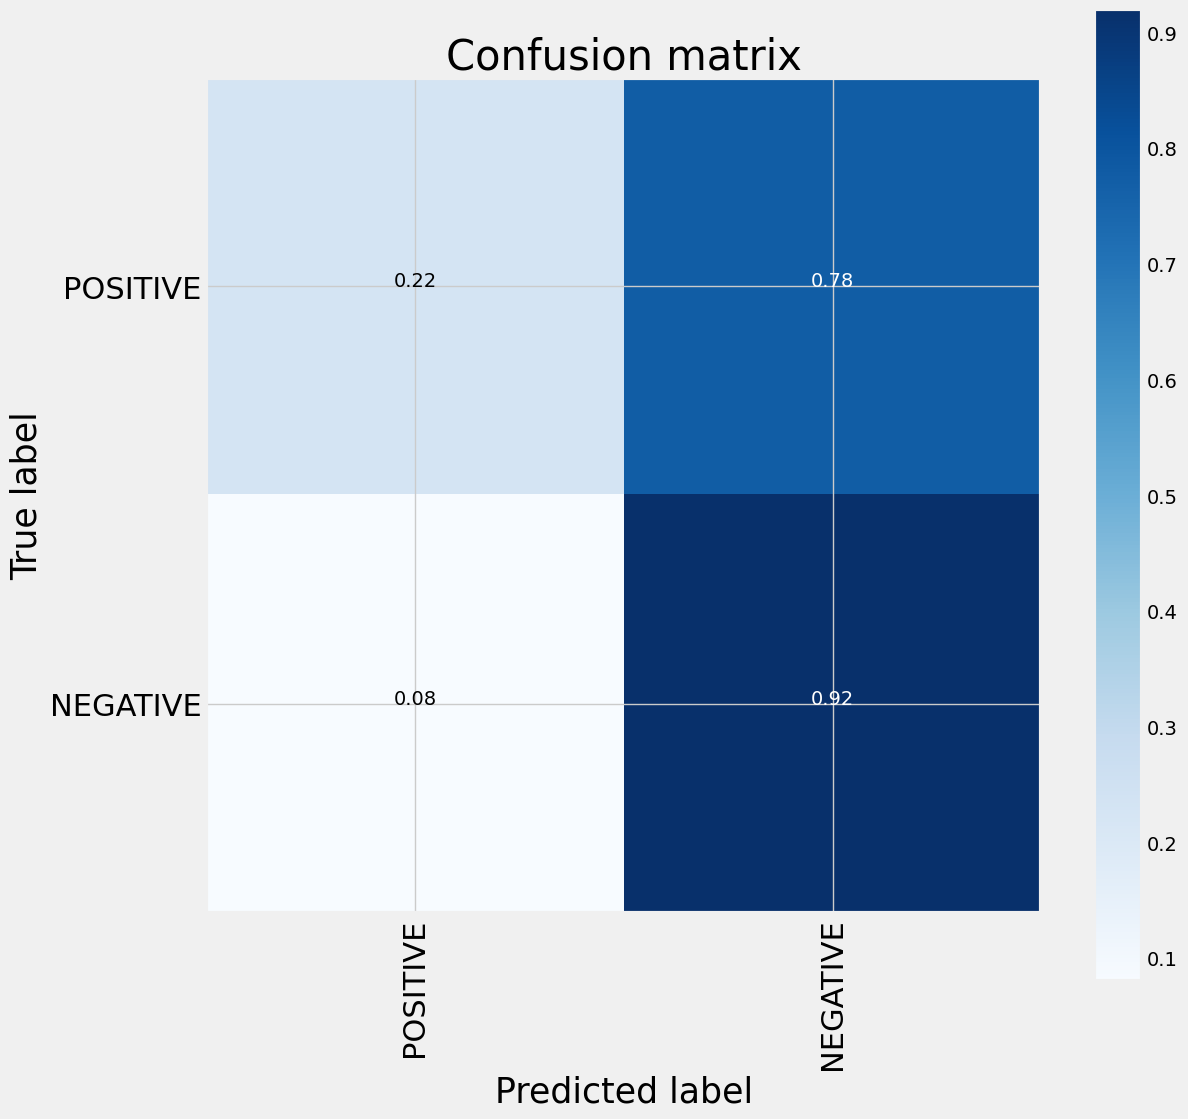

CPU times: user 578 ms, sys: 310 ms, total: 888 ms
Wall time: 674 ms


In [54]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.category.unique(), title="Confusion matrix")
plt.show()

In [55]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.58      0.22      0.32      7026
    POSITIVE       0.71      0.92      0.80     14526

    accuracy                           0.69     21552
   macro avg       0.64      0.57      0.56     21552
weighted avg       0.67      0.69      0.65     21552



In [56]:
accuracy_score(y_test_1d, y_pred_1d)

0.6933927245731255